In [31]:
# imports 
import numpy as np
import os, sys
import monai
from monai.data import CacheDataset, DataLoader, GridPatchDataset
from monai.transforms import (
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    LoadImaged,
    Resized,
    ScaleIntensityd,
    SqueezeDimd,
    MapLabelValued,
    LoadImage,
    Rotated,
    Flipd,
    SpatialPadd,
    SpatialResampled,
    Spacingd,
    Orientationd,
)

import itertools


from sklearn.model_selection import KFold

from monai.networks.nets import UNet

import math
import matplotlib.pyplot as plt
import glob
import torch
import SimpleITK as sitk

In [79]:
import sys
sys.path.insert(0, '..')
from transforms import CropAroundMaskd

In [47]:
data_dir = "../preprocessed/CT/annotated"

print(data_dir)
k_folds = 6

all_images = sorted(glob.glob(os.path.join(data_dir, "images/case_10*")))
all_labels = sorted(glob.glob(os.path.join(data_dir, "labels/case_10*")))
train_images = [*range(0,18), *range(20, 38)] 
print((train_images))
# print(all_images)

kf = KFold(n_splits=k_folds, shuffle=True)
for train_idx, val_idx in kf.split(train_images):


    print("TRAIN:", train_idx, "VAL:", val_idx)
    continue
    train_images = [glob.glob(all_images[idx]+ "/*.nii.gz") for idx in train_idx]
    train_images = sorted(list(itertools.chain.from_iterable(train_images)))

    train_labels = [glob.glob(all_labels[idx]+ "/*.nii.gz") for idx in train_idx]
    train_labels = sorted(list(itertools.chain.from_iterable(train_labels)))
    train_files = [{"img": img, "seg": seg} for img, seg in zip(train_images, train_labels)]


    val_images = [glob.glob(all_images[idx]+ "/*.nii.gz") for idx in val_idx]
    val_images = sorted(list(itertools.chain.from_iterable(val_images)))

    val_labels = [glob.glob(all_labels[idx]+ "/*.nii.gz") for idx in val_idx]
    val_labels = sorted(list(itertools.chain.from_iterable(val_labels)))

    val_files = [{"img": img, "seg": seg} for img, seg in zip(val_images, val_labels)]
        


../preprocessed/CT/annotated
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]
TRAIN: [ 0  2  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 31 32 33 34] VAL: [ 1  3  4  7 30 35]
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21 22 24 26 27
 28 29 30 33 34 35] VAL: [ 0 12 23 25 31 32]
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 18 19 20 21 23 25 26 27
 28 29 30 31 32 35] VAL: [ 9 17 22 24 33 34]
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 15 16 17 18 19 21 22 23 24 25 26
 30 31 32 33 34 35] VAL: [ 6 14 20 27 28 29]
TRAIN: [ 0  1  2  3  4  6  7  8  9 12 13 14 17 18 19 20 21 22 23 24 25 27 28 29
 30 31 32 33 34 35] VAL: [ 5 10 11 15 16 26]
TRAIN: [ 0  1  3  4  5  6  7  9 10 11 12 14 15 16 17 20 22 23 24 25 26 27 28 29
 30 31 32 33 34 35] VAL: [ 2  8 13 18 19 21]


In [5]:
data_dir = "../preprocessed/CT/annotated"

print(data_dir)


train_images2 = sorted(glob.glob(os.path.join(data_dir, "images/case_1019/*.nii.gz")))
print(len(train_images2))
print(train_images2[-1])


train_images = sorted(glob.glob(os.path.join(data_dir, "images/case_1019/*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labels/case_1019/*.nii.gz")))

print(len(train_images))

train_files = [{"img": img, "seg": seg} for img, seg in zip(train_images, train_labels)]
print("nr train files:", len(train_files))

../preprocessed/CT/annotated
297
../preprocessed/CT/annotated/images/case_1019/slice_4941.nii.gz
297
nr train files: 297


In [10]:
data_dir = "../../MMWHS_Dataset/ct_train"
images = sorted(glob.glob(os.path.join(data_dir, "ct_train_1010_image.nii.gz")))
labels = sorted(glob.glob(os.path.join(data_dir, "ct_train_1010_label.nii.gz")))

example_dataset = [{"img": img, "seg": seg} for img, seg in zip(images, labels)]
print(len(example_dataset))
case = 1010

1


In [81]:
# loaded_img = LoadImaged(keys=['img', 'seg'], image_only=False)(example_dataset[0])
# print(loaded_img['img_meta_dict'])



# CHECK 1011 and 1012

In [82]:
volume_transforms = Compose(
        [
            LoadImaged(keys=["img", "seg"]),
            EnsureChannelFirstd(keys=["img", "seg"]),
            ScaleIntensityd(keys="img"), # normalization between 0 and 1 # segmentation masl also?
            EnsureTyped(keys=["img", "seg"]),
            Spacingd(keys=["img"], pixdim=(1, 1, 1), mode = 'bilinear'),
            Spacingd(keys=["seg"], pixdim=(1, 1, 1), mode = 'nearest'),
            # Resized(keys=["img"], spatial_size=(160, 160, 160), mode = 'bilinear'), 
            # Resized(keys=["seg"], spatial_size=(160, 160, 160), mode = 'nearest'),
             # resample to 1mm spacing with isotropic voxel size
            Orientationd(keys=["img", "seg"], axcodes="LPI"),
            CropAroundMaskd(keys=["img", "seg"], extra_spacing=1.2),
        ])  

In [83]:
volume_ds_person1 = CacheDataset(data=example_dataset, transform=volume_transforms, cache_rate=1.0, num_workers=4) # experiment with last two parameters
check_loader = DataLoader(volume_ds_person1, batch_size=1)
check_data = monai.utils.misc.first(check_loader)

Loading dataset: 100%|██████████| 1/1 [00:16<00:00, 16.68s/it]


In [84]:
print("first volume's shape", check_data["img"].shape, check_data["seg"].shape)
spat_size = check_data["img"].shape[4]
print("spatial size", spat_size)


first volume's shape torch.Size([1, 1, 168, 168, 280]) torch.Size([1, 1, 168, 168, 280])
spatial size 280


In [85]:
patch_func = monai.data.PatchIterd(
    keys=["img", "seg"],
    patch_size=(None, None, 1),  # dynamic first two dimensions (None, 1, None)
    start_pos=(0, 0, 0)
)
patch_transform = Compose(
        [
            #SpatialPadd(keys=["img", "seg"], spatial_size=[256,1,256]),# mode = "bilinear"),# size_mode="all"),
            Resized(keys=["img"], spatial_size=[256,256, 1], mode = "bilinear"),
            Resized(keys=["seg"], spatial_size=[256,256,1], mode = "nearest"),
        
            MapLabelValued(keys=["seg"], orig_labels=[205, 420, 500, 550, 600, 820, 850, 421], target_labels=[1, 2, 3, 4, 5 , 6 , 7, 0]),
            #SpatialPadd(keys=["img", "seg"], spatial_size=[256, 1, 256]),#, mode="zeros"),
            SqueezeDimd(keys=["img", "seg"], dim=0),  # squeeze the first dim
        ]
    )

filenames_ct = [f"{case}_slice_orig.nii.gz", f"{case}_slice_resized.nii.gz", f"{case}_slice_cropped_resize.nii.gz"]
filename = f"{case}_slice_boundingbox_crop.nii.gz"


example_patch_ds = GridPatchDataset(data=volume_ds_person1, patch_iter=patch_func, transform=patch_transform)
patch_data_loader = DataLoader(example_patch_ds, batch_size=1, num_workers=2, pin_memory=torch.cuda.is_available())


In [86]:
i = 1
current_directory = os.getcwd()
output_dir_image = "../preprocessed/mr_examples/images"
output_dir_label = "../preprocessed/mr_examples/labels"

os.makedirs(output_dir_image, exist_ok=True)
os.makedirs(output_dir_label, exist_ok=True)

j=0
for batch in patch_data_loader:
    image, label = batch[0]["img"], batch[0]["seg"]
    j += 1
    if j > spat_size/2:
        # image = image.squeeze(0)
        # label = label.squeeze(0)
        print("image shape", image.shape, "label shape", label.shape)

        # Convert the torch tensor to a SimpleITK image
        slice_image = sitk.GetImageFromArray(image)
        slice_label = sitk.GetImageFromArray(label)
        # # Save the 2D slice as a NIfTI file
        print(output_dir_image, filename)
        sitk.WriteImage(slice_image, os.path.join(output_dir_image, filename))
        sitk.WriteImage(slice_label, os.path.join(output_dir_label, filename))
        i += 1
        break

print("Total number of slices:", i)

image shape torch.Size([1, 256, 256, 1]) label shape torch.Size([1, 256, 256, 1])
../preprocessed/mr_examples/images 1010_slice_boundingbox_crop.nii.gz
Total number of slices: 2


image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


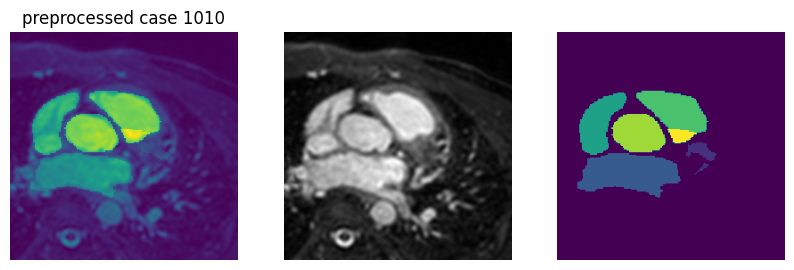

In [87]:
file_original = f"../preprocessed/CT/annota/{case}_slice_boundingbox_crop.nii.gz"
example_im_original = LoadImage(image_only=True, simple_keys=True)(file_original)
print(f"image data shape: {example_im_original.shape}")

label_original = f"../preprocessed/mr_examples/labels/{case}_slice_boundingbox_crop.nii.gz"
example_label_original = LoadImage(image_only=True, simple_keys=True)(label_original)
print(f"label data shape: {example_label_original.shape}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title(f"preprocessed case {case}")
plt.axis("off")
plt.imshow((example_im_original + example_label_original/10) / 2)
plt.subplot(1, 3, 2)
plt.axis("off")
plt.imshow(example_im_original, cmap="gray")
plt.subplot(1, 3, 3)
plt.axis("off")
plt.imshow(example_label_original)
plt.show()

In [88]:
d

NameError: name 'd' is not defined

image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


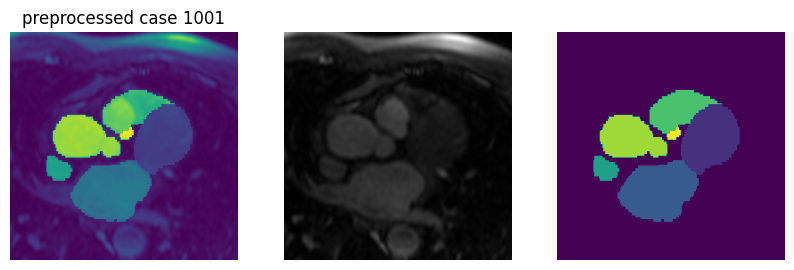

image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


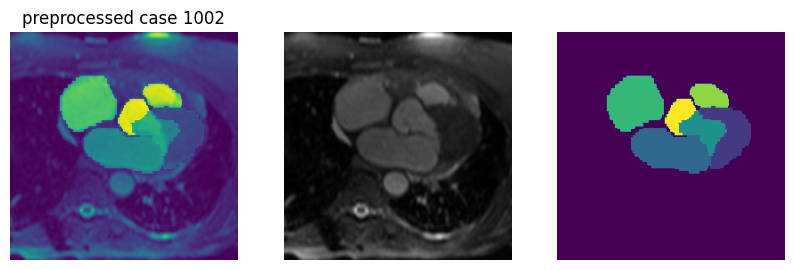

image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


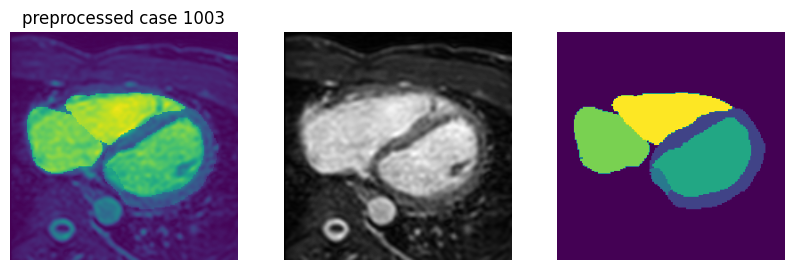

FileNotFoundError: No such file or no access: '../preprocessed/mr_examples/images/1004_slice_boundingbox_crop.nii.gz'

In [ ]:
for case in range(1001, 1021): # 1001
    file_original = f"../preprocessed/mr_examples/images/{case}_slice_boundingbox_crop.nii.gz"
    example_im_original = LoadImage(image_only=True, simple_keys=True)(file_original)
    print(f"image data shape: {example_im_original.shape}")

    label_original = f"../preprocessed/mr_examples/labels/{case}_slice_boundingbox_crop.nii.gz"
    example_label_original = LoadImage(image_only=True, simple_keys=True)(label_original)
    print(f"label data shape: {example_label_original.shape}")

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.title(f"preprocessed case {case}")
    plt.axis("off")
    plt.imshow((example_im_original + example_label_original/10) / 2)
    plt.subplot(1, 3, 2)
    plt.axis("off")
    plt.imshow(example_im_original, cmap="gray")
    plt.subplot(1, 3, 3)
    plt.axis("off")
    plt.imshow(example_label_original)
    plt.show()

image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


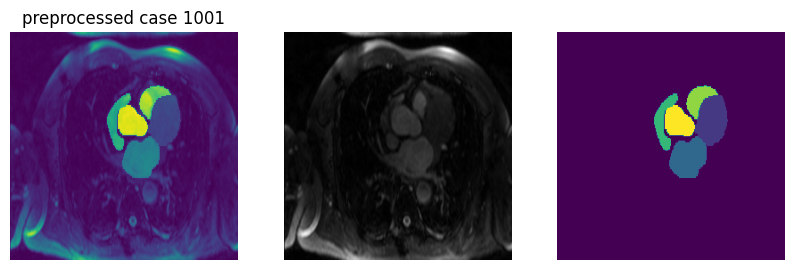

image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


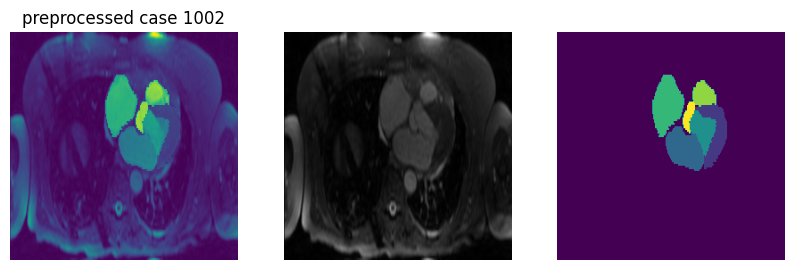

image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


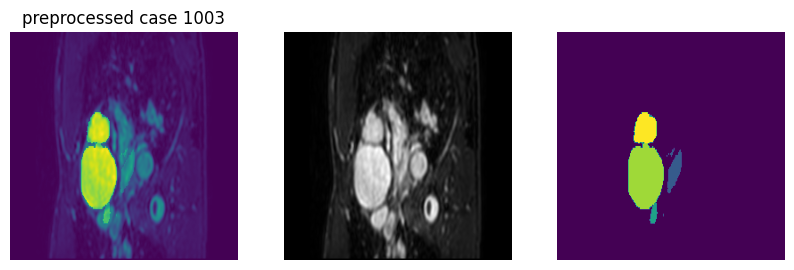

FileNotFoundError: No such file or no access: '../preprocessed/mr_examples/images/1004_slice_resized.nii.gz'

In [ ]:
# original
filenames = [f"{case}_slice_orig.nii.gz", f"{case}_spacing_orient.nii.gz", f"{case}_slice_boundingbox_crop.nii.gz"]

for case in range(1001, 1021):
    file_original = f"../preprocessed/mr_examples/images/{case}_slice_orig.nii.gz"
    example_im_original = LoadImage(image_only=True, simple_keys=True)(file_original)
    print(f"image data shape: {example_im_original.shape}")

    label_original = f"../preprocessed/mr_examples/labels/{case}_slice_orig.nii.gz"
    example_label_original = LoadImage(image_only=True, simple_keys=True)(label_original)
    print(f"label data shape: {example_label_original.shape}")

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.title(f"preprocessed case {case}")
    plt.axis("off")
    plt.imshow((example_im_original + example_label_original/10) / 2)
    plt.subplot(1, 3, 2)
    plt.axis("off")
    plt.imshow(example_im_original, cmap="gray")
    plt.subplot(1, 3, 3)
    plt.axis("off")
    plt.imshow(example_label_original)
    plt.show()

In [ ]:
# Spacing and orientation
filenames = [f"{case}_slice_orig.nii.gz", f"{case}_spacing_orient.nii.gz", f"{case}_slice_boundingbox_crop.nii.gz"]

for case in range(1001, 1021):
    file_original = f"../preprocessed/mr_examples/images/{case}_spacing_orient.nii.gz"
    example_im_original = LoadImage(image_only=True, simple_keys=True)(file_original)
    print(f"image data shape: {example_im_original.shape}")

    label_original = f"../preprocessed/mr_examples/labels/{case}_spacing_orient.nii.gz"
    example_label_original = LoadImage(image_only=True, simple_keys=True)(label_original)
    print(f"label data shape: {example_label_original.shape}")

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.title(f"preprocessed case {case}")
    plt.axis("off")
    plt.imshow((example_im_original + example_label_original/10) / 2)
    plt.subplot(1, 3, 2)
    plt.axis("off")
    plt.imshow(example_im_original, cmap="gray")
    plt.subplot(1, 3, 3)
    plt.axis("off")
    plt.imshow(example_label_original)
    plt.show()

image data shape: torch.Size([1, 256, 256, 1])
label data shape: torch.Size([256, 256, 1])


TypeError: Invalid shape (1, 256, 256, 1) for image data

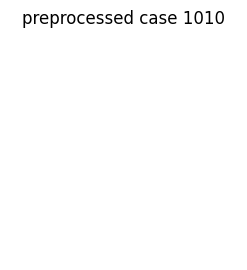

In [8]:
from monai.transforms import EnsureChannelFirst

case = 1010
file_original = f"../preprocessed/CT/annotated/images/case_1010/slice_2430.nii.gz"
example_im_original = LoadImage(image_only=True, simple_keys=True)(file_original)
example_im_original = EnsureChannelFirst()(example_im_original)
print(f"image data shape: {example_im_original.shape}")

label_original = f"../preprocessed/CT/annotated/labels/case_1010/slice_2430.nii.gz"
example_label_original = LoadImage(image_only=True, simple_keys=True)(label_original)
print(f"label data shape: {example_label_original.shape}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title(f"preprocessed case {case}")
plt.axis("off")
plt.imshow((example_im_original + example_label_original/10) / 2)
plt.subplot(1, 3, 2)
plt.axis("off")
plt.imshow(example_im_original, cmap="gray")
plt.subplot(1, 3, 3)
plt.axis("off")
plt.imshow(example_label_original)
plt.show()

image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


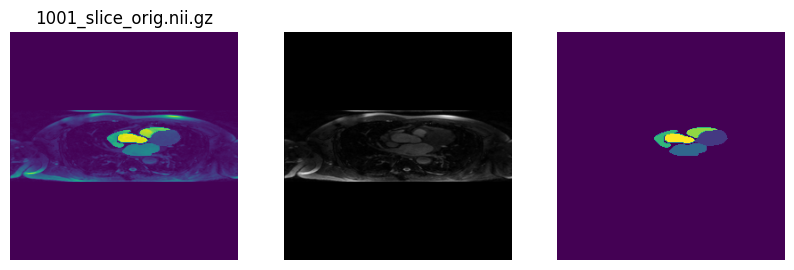

image data shape: torch.Size([255, 400, 1])
label data shape: torch.Size([255, 400, 1])


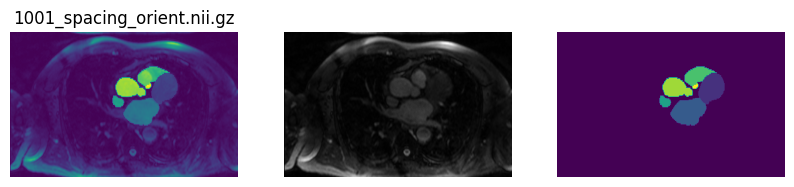

image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


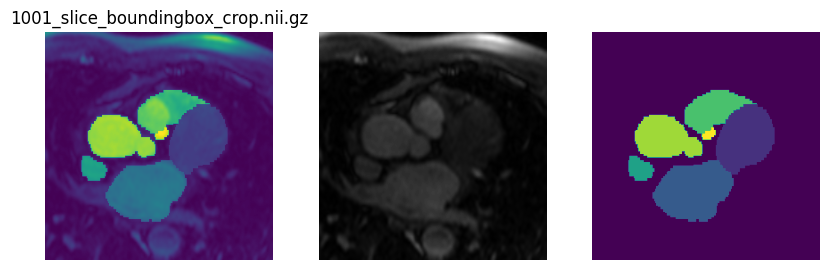

In [133]:
# Spacing and orientation
case = 1001
filenames = [f"{case}_slice_orig.nii.gz", f"{case}_spacing_orient.nii.gz", f"{case}_slice_boundingbox_crop.nii.gz"]

for filename in filenames:
    file_original = f"../preprocessed/mr_examples/images/{filename}"
    example_im_original = LoadImage(image_only=True, simple_keys=True)(file_original)
    print(f"image data shape: {example_im_original.shape}")

    label_original = f"../preprocessed/mr_examples/labels/{filename}"
    example_label_original = LoadImage(image_only=True, simple_keys=True)(label_original)
    print(f"label data shape: {example_label_original.shape}")

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.title(f"{filename}")
    plt.axis("off")
    plt.imshow((example_im_original + example_label_original/10) / 2)
    plt.subplot(1, 3, 2)
    plt.axis("off")
    plt.imshow(example_im_original, cmap="gray")
    plt.subplot(1, 3, 3)
    plt.axis("off")
    plt.imshow(example_label_original)
    plt.show()

In [ ]:
d

image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


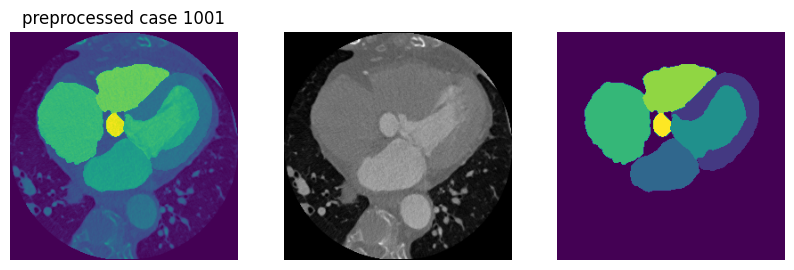

image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


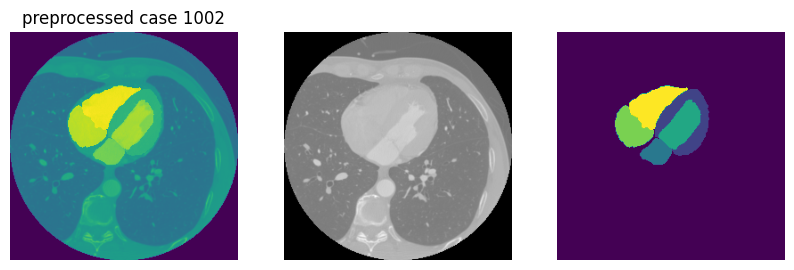

image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


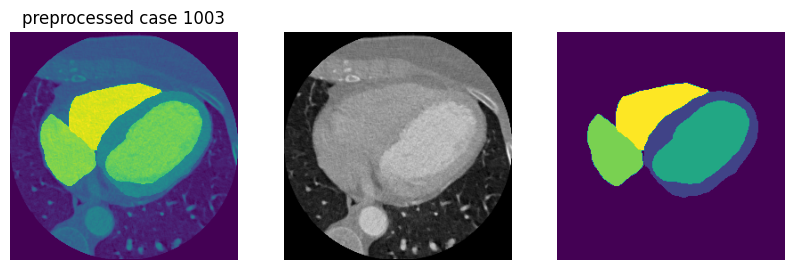

image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


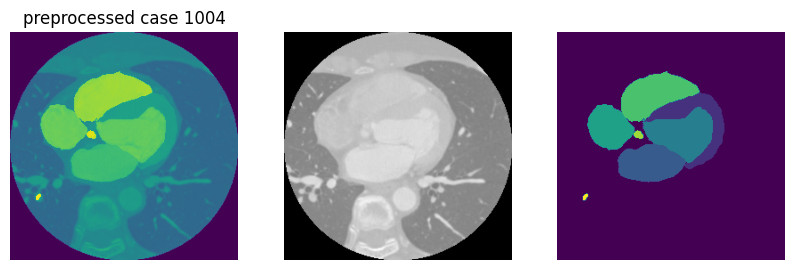

image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


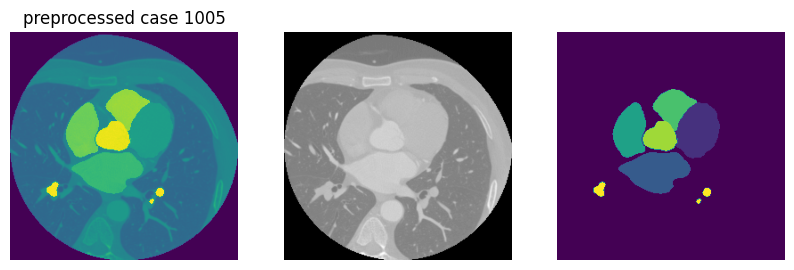

image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


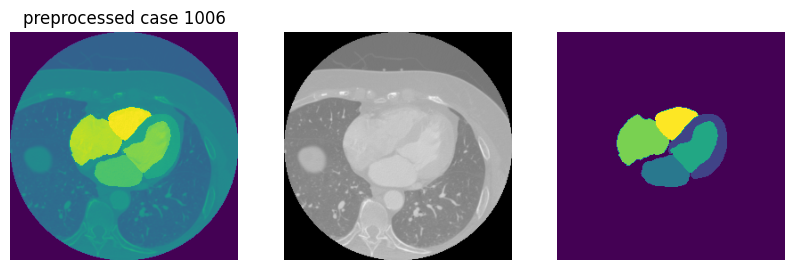

image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


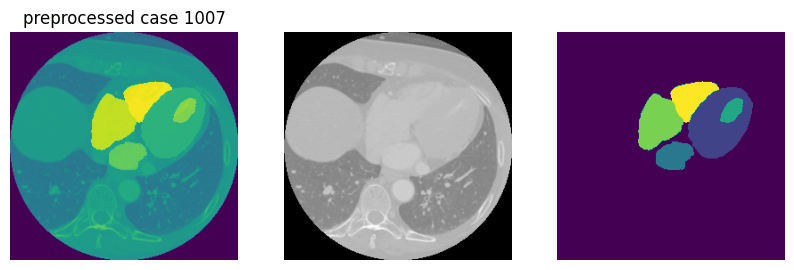

image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


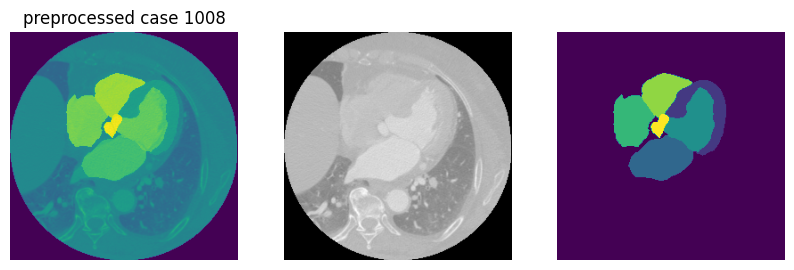

image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


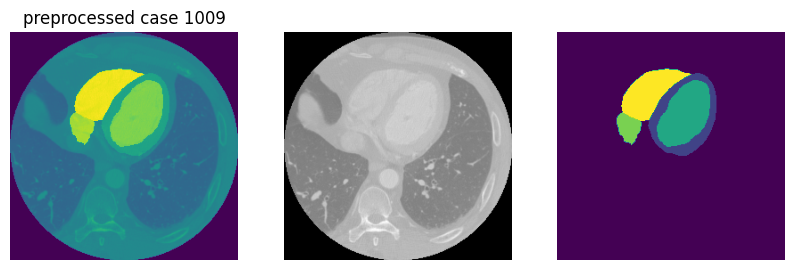

image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


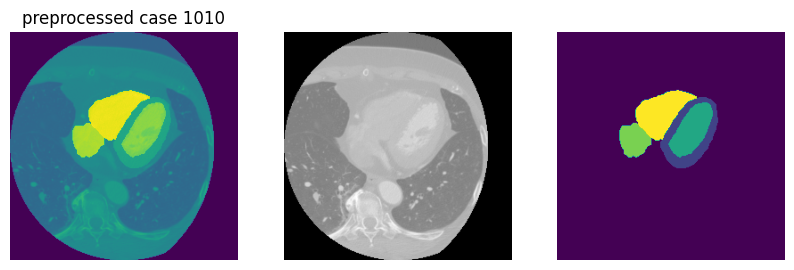

image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


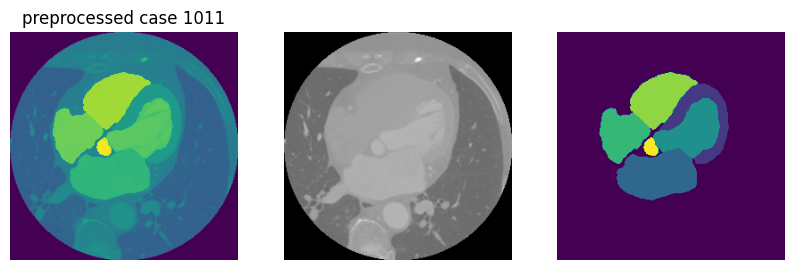

image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


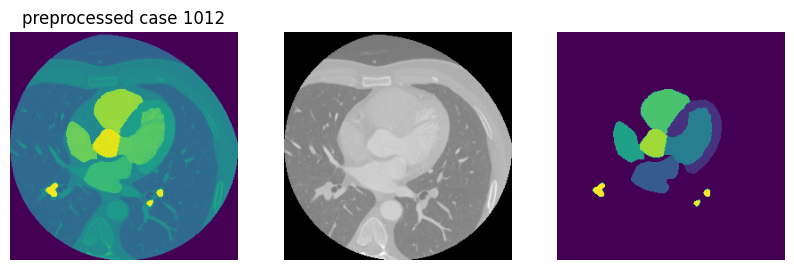

image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


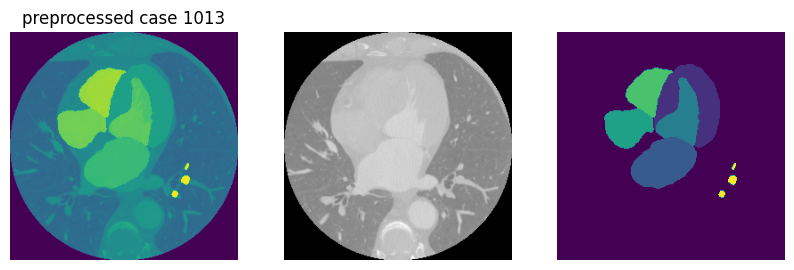

image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


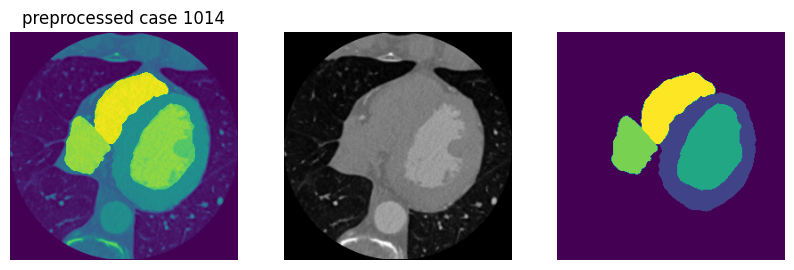

image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


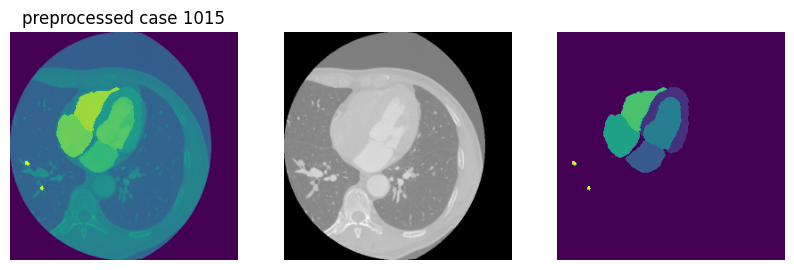

image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


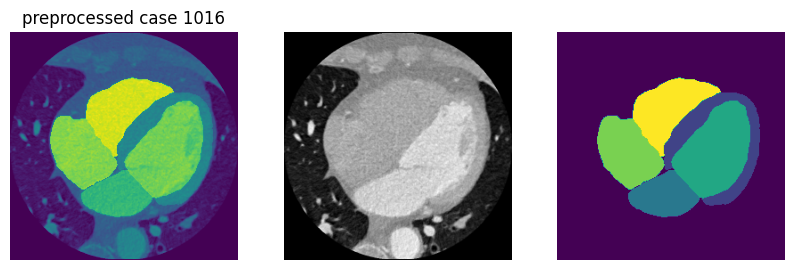

image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


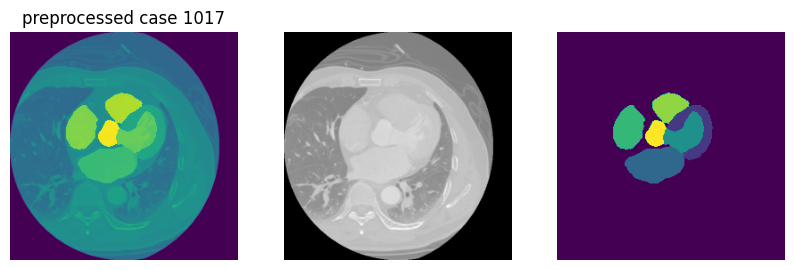

image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


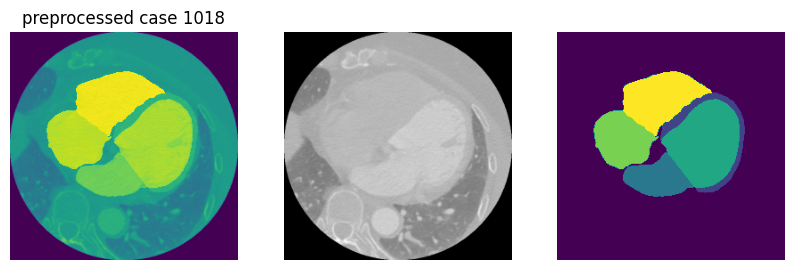

image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


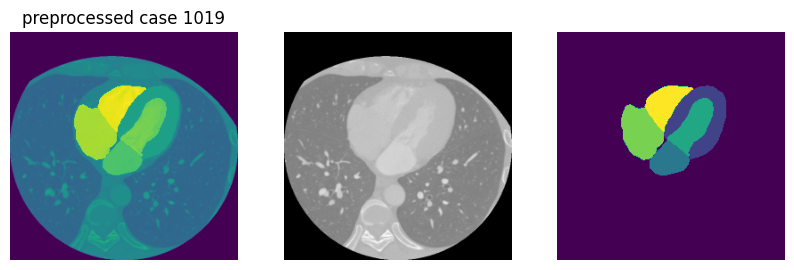

image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


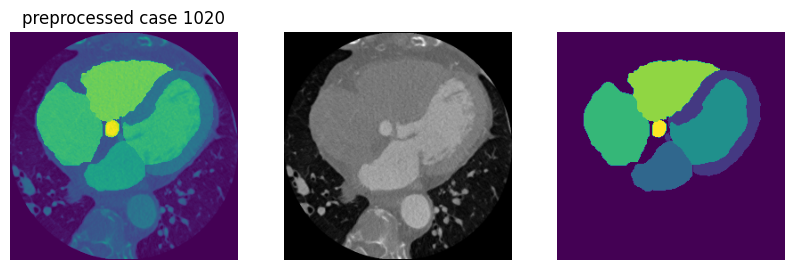

In [ ]:
# original, mapped, flipped, resized
for case in range(1001, 1021):
    file_original = f"../preprocessed/ct_examples/images/{case}_slice_orig_map_flip_resize.nii.gz"
    example_im_original = LoadImage(image_only=True, simple_keys=True)(file_original)
    print(f"image data shape: {example_im_original.shape}")

    label_original = f"../preprocessed/ct_examples/labels/{case}_slice_orig_map_flip_resize.nii.gz"
    example_label_original = LoadImage(image_only=True, simple_keys=True)(label_original)
    print(f"label data shape: {example_label_original.shape}")

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.title(f"preprocessed case {case}")
    plt.axis("off")
    plt.imshow((example_im_original + example_label_original/10) / 2)
    plt.subplot(1, 3, 2)
    plt.axis("off")
    plt.imshow(example_im_original, cmap="gray")
    plt.subplot(1, 3, 3)
    plt.axis("off")
    plt.imshow(example_label_original)
    plt.show()

In [ ]:
# original
file_original = f"../preprocessed/ct_examples/images/{case}_slice_orig.nii.gz"
example_im_original = LoadImage(image_only=True, simple_keys=True)(file_original)
print(f"image data shape: {example_im_original.shape}")

label_original = f"../preprocessed/ct_examples/labels/{case}_slice_orig.nii.gz"
example_label_original = LoadImage(image_only=True, simple_keys=True)(label_original)
print(f"label data shape: {example_label_original.shape}")

# transformed
file_original_map = f"../preprocessed/ct_examples/images/{case}_slice_cropped.nii.gz"
example_im_original_map = LoadImage(image_only=True, simple_keys=True)(file_original_map)
print(f"image data shape: {example_im_original_map.shape}")

label_original_map = f"../preprocessed/ct_examples/labels/{case}_slice_cropped.nii.gz"
example_label_original_map = LoadImage(image_only=True, simple_keys=True)(label_original_map)
print(f"label data shape: {example_label_original_map.shape}")

# transformed and resized
file_original_map_flip = f"../preprocessed/ct_examples/images/{case}_slice_cropped_resize.nii.gz"
example_im_original_map_flip = LoadImage(image_only=True, simple_keys=True)(file_original_map_flip)
print(f"image data shape: {example_im_original_map_flip.shape}")

label_original_map_flip = f"../preprocessed/ct_examples/labels/{case}_slice_cropped_resize.nii.gz"
example_label_original_map_flip = LoadImage(image_only=True, simple_keys=True)(label_original_map_flip)
print(f"label data shape: {example_label_original_map_flip.shape}")


In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(3, 3, 1)
plt.title("original")
plt.axis("off")
plt.imshow((example_im_original + example_label_original/1000) / 2)
plt.subplot(3, 3, 2)
plt.axis("off")
plt.imshow(example_im_original, cmap="gray")
plt.subplot(3, 3, 3)
plt.axis("off")
plt.imshow(example_label_original)

plt.subplot(3, 3, 4)
plt.title("transform")
plt.axis("off")
plt.imshow((example_im_original_map + example_label_original_map/10) / 2)
plt.subplot(3, 3, 5)
plt.axis("off")
plt.imshow(example_im_original_map, cmap="gray")
plt.subplot(3, 3, 6)
plt.axis("off")
plt.imshow(example_label_original_map)

plt.subplot(3, 3, 7)
plt.title("transform+resize")
plt.axis("off")
plt.imshow((example_im_original_map_flip + example_label_original_map_flip/10) / 2)
plt.subplot(3, 3, 8)
plt.axis("off")
plt.imshow(example_im_original_map_flip, cmap="gray")
plt.subplot(3, 3, 9)
plt.axis("off")
plt.imshow(example_label_original_map_flip)


plt.tight_layout()